# Credit Card Fraud Detection - Shirley Sinha

## Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt

from sklearn.preprocessing import OrdinalEncoder,LabelEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import roc_auc_score


import json
import csv

In [2]:
#converting text to csv 

def json_to_csv(txt_file, csv_file):

    lista = []
    with open(txt_file, 'r') as in_file:
        lines = in_file.readlines()
        for line in lines:
            try:
                dict_line = json.loads(line)
                lista.append(dict_line)
            except Exception as err:
                print(err)

    header = ['accountNumber', 'customerId', 'creditLimit', 'availableMoney',
       'transactionDateTime', 'transactionAmount', 'merchantName',
       'acqCountry', 'merchantCountryCode', 'posEntryMode', 'posConditionCode',
       'merchantCategoryCode', 'currentExpDate', 'accountOpenDate',
       'dateOfLastAddressChange', 'cardCVV', 'enteredCVV', 'cardLast4Digits',
       'transactionType', 'echoBuffer', 'currentBalance', 'merchantCity',
       'merchantState', 'merchantZip', 'cardPresent', 'posOnPremises',
       'recurringAuthInd', 'expirationDateKeyInMatch', 'isFraud'
        
    ]
    with open(csv_file, 'w+') as out_file:
        dict_writer = csv.DictWriter(out_file, header)
        dict_writer.writeheader()
        dict_writer.writerows(lista)

In [3]:
json_to_csv('transactions.txt', 'transactions.csv')

## Reading Data

In [4]:
df = pd.read_csv('transactions.csv')

In [5]:
df.head()

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,...,echoBuffer,currentBalance,merchantCity,merchantState,merchantZip,cardPresent,posOnPremises,recurringAuthInd,expirationDateKeyInMatch,isFraud
0,737265056,737265056,5000.0,5000.0,2016-08-13T14:27:32,98.55,Uber,US,US,2.0,...,NaN,0.0,NaN,NaN,NaN,False,NaN,NaN,False,False
1,737265056,737265056,5000.0,5000.0,2016-10-11T05:05:54,74.51,AMC #191138,US,US,9.0,...,NaN,0.0,NaN,NaN,NaN,True,NaN,NaN,False,False
2,737265056,737265056,5000.0,5000.0,2016-11-08T09:18:39,7.47,Play Store,US,US,9.0,...,NaN,0.0,NaN,NaN,NaN,False,NaN,NaN,False,False
3,737265056,737265056,5000.0,5000.0,2016-12-10T02:14:50,7.47,Play Store,US,US,9.0,...,NaN,0.0,NaN,NaN,NaN,False,NaN,NaN,False,False
4,830329091,830329091,5000.0,5000.0,2016-03-24T21:04:46,71.18,Tim Hortons #947751,US,US,2.0,...,NaN,0.0,NaN,NaN,NaN,True,NaN,NaN,False,False


In [6]:
df.shape

(786363, 29)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 786363 entries, 0 to 786362
Data columns (total 29 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   accountNumber             786363 non-null  int64  
 1   customerId                786363 non-null  int64  
 2   creditLimit               786363 non-null  float64
 3   availableMoney            786363 non-null  float64
 4   transactionDateTime       786363 non-null  object 
 5   transactionAmount         786363 non-null  float64
 6   merchantName              786363 non-null  object 
 7   acqCountry                781801 non-null  object 
 8   merchantCountryCode       785639 non-null  object 
 9   posEntryMode              782309 non-null  float64
 10  posConditionCode          785954 non-null  float64
 11  merchantCategoryCode      786363 non-null  object 
 12  currentExpDate            786363 non-null  object 
 13  accountOpenDate           786363 non-null  o

## Data Cleaning

In [8]:
#remove empty columns

df = df.drop(['echoBuffer','merchantCity','merchantState','merchantZip','posOnPremises', 'recurringAuthInd'], axis = 1)

In [9]:
df.isnull().sum()

accountNumber                  0
customerId                     0
creditLimit                    0
availableMoney                 0
transactionDateTime            0
transactionAmount              0
merchantName                   0
acqCountry                  4562
merchantCountryCode          724
posEntryMode                4054
posConditionCode             409
merchantCategoryCode           0
currentExpDate                 0
accountOpenDate                0
dateOfLastAddressChange        0
cardCVV                        0
enteredCVV                     0
cardLast4Digits                0
transactionType              698
currentBalance                 0
cardPresent                    0
expirationDateKeyInMatch       0
isFraud                        0
dtype: int64

In [10]:
df['merchantName'].unique()

array(['Uber', 'AMC #191138', 'Play Store', ..., 'ATT #141119',
       'EZ Wireless #200746', 'Runners #747070'], dtype=object)

In [11]:
df['merchantName'].nunique()

2490

In [12]:
df['acqCountry'].unique()

array(['US', nan, 'CAN', 'MEX', 'PR'], dtype=object)

In [13]:
df['merchantCountryCode'].unique()

array(['US', 'CAN', nan, 'PR', 'MEX'], dtype=object)

In [14]:
df['posEntryMode'].unique()

array([ 2.,  9.,  5., 80., 90., nan])

In [15]:
df['posConditionCode'].unique()

array([ 1.,  8., 99., nan])

In [16]:
df['transactionType'].unique()

array(['PURCHASE', 'ADDRESS_VERIFICATION', 'REVERSAL', nan], dtype=object)

In [17]:
#replacing nan values

df['acqCountry'] = df['acqCountry'].fillna(df['acqCountry'].mode().iloc[0])
df['merchantCountryCode'] = df['merchantCountryCode'].fillna(df['merchantCountryCode'].mode().iloc[0])
df['posEntryMode'] = df['posEntryMode'].fillna(df['posEntryMode'].mode().iloc[0])
df['posConditionCode'] = df['posConditionCode'].fillna(df['posConditionCode'].mode().iloc[0])
df['transactionType'] = df['transactionType'].fillna(df['transactionType'].mode().iloc[0])

In [18]:
def CVV(df):

    if (df['cardCVV'] == df['enteredCVV']):
        return 'Correct'
    else:
        return 'NotCorrect'



In [19]:
df['CorrectCVV'] = df.apply(CVV,axis =1)

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 786363 entries, 0 to 786362
Data columns (total 24 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   accountNumber             786363 non-null  int64  
 1   customerId                786363 non-null  int64  
 2   creditLimit               786363 non-null  float64
 3   availableMoney            786363 non-null  float64
 4   transactionDateTime       786363 non-null  object 
 5   transactionAmount         786363 non-null  float64
 6   merchantName              786363 non-null  object 
 7   acqCountry                786363 non-null  object 
 8   merchantCountryCode       786363 non-null  object 
 9   posEntryMode              786363 non-null  float64
 10  posConditionCode          786363 non-null  float64
 11  merchantCategoryCode      786363 non-null  object 
 12  currentExpDate            786363 non-null  object 
 13  accountOpenDate           786363 non-null  o

In [21]:
#remove unnecessary columns
df = df.drop(['accountNumber','customerId','merchantName'], axis = 1)
df = df.drop(['transactionDateTime','currentExpDate','accountOpenDate','dateOfLastAddressChange',
              'cardCVV','enteredCVV','cardLast4Digits'],axis = 1)

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 786363 entries, 0 to 786362
Data columns (total 14 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   creditLimit               786363 non-null  float64
 1   availableMoney            786363 non-null  float64
 2   transactionAmount         786363 non-null  float64
 3   acqCountry                786363 non-null  object 
 4   merchantCountryCode       786363 non-null  object 
 5   posEntryMode              786363 non-null  float64
 6   posConditionCode          786363 non-null  float64
 7   merchantCategoryCode      786363 non-null  object 
 8   transactionType           786363 non-null  object 
 9   currentBalance            786363 non-null  float64
 10  cardPresent               786363 non-null  bool   
 11  expirationDateKeyInMatch  786363 non-null  bool   
 12  isFraud                   786363 non-null  bool   
 13  CorrectCVV                786363 non-null  o

In [23]:
#changing datatype

df['posEntryMode']=df['posEntryMode'].astype(object)
df['posConditionCode']=df['posConditionCode'].astype(object)

df['cardPresent']=df['cardPresent'].astype(object)
df['expirationDateKeyInMatch']=df['expirationDateKeyInMatch'].astype(object)

In [24]:
df['isFraud'].value_counts()

False    773946
True      12417
Name: isFraud, dtype: int64

In [25]:
df['isFraud'] = df['isFraud'].replace(True, 1)
df['isFraud'] = df['isFraud'].replace(False, 0)

The target variable isFraud has 0 and 1 values. Here
0 for non-fraudulent transactions,
1 for fraudulent transactions

### Data Visualization

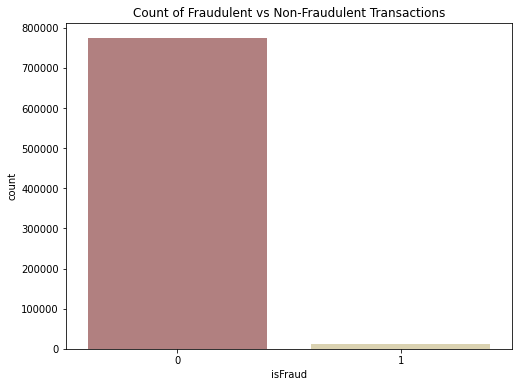

In [26]:
plt.rcParams['figure.figsize'] = (8,6)
sns.countplot(x = df['isFraud'], palette = 'pink')
plt.title("Count of Fraudulent vs Non-Fraudulent Transactions")
plt.show()

<AxesSubplot:title={'center':'Distribution of Monetary Value Feature'}, xlabel='transactionAmount', ylabel='Count'>

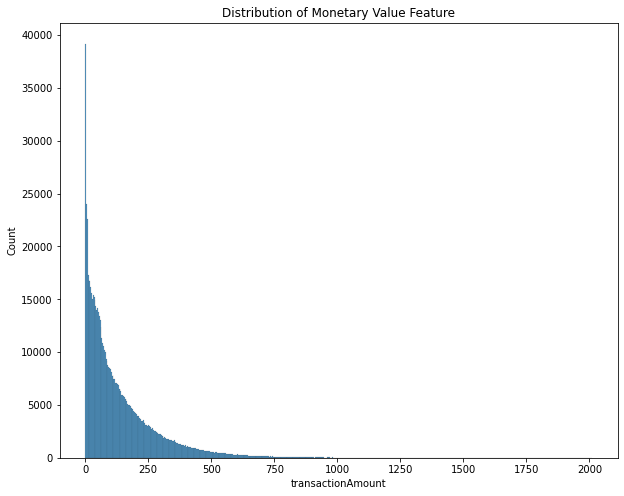

In [27]:
plt.figure(figsize=(10,8))
plt.title('Distribution of Monetary Value Feature')
sns.histplot(df.transactionAmount)

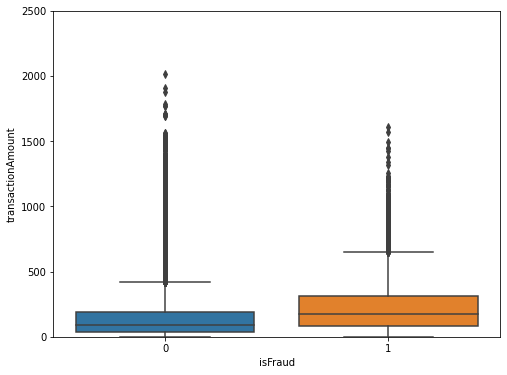

In [28]:
sns.boxplot(x = "isFraud", y = "transactionAmount", data = df)
plt.ylim(0, 2500)
plt.show()

Observations:

From above box plot we can easily infer that there are no fraud transactions occur above the transaction amount of 2000. All of the fraud transactions have transaction amount less than 2000. However, all transactions (genuine or not), have transaction amount less than 2000.

*Feature 'isFraud' is the response variable and it takes value 1 in case of fraud and 0 otherwise.*

/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/seaborn/axisgrid.py:316: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


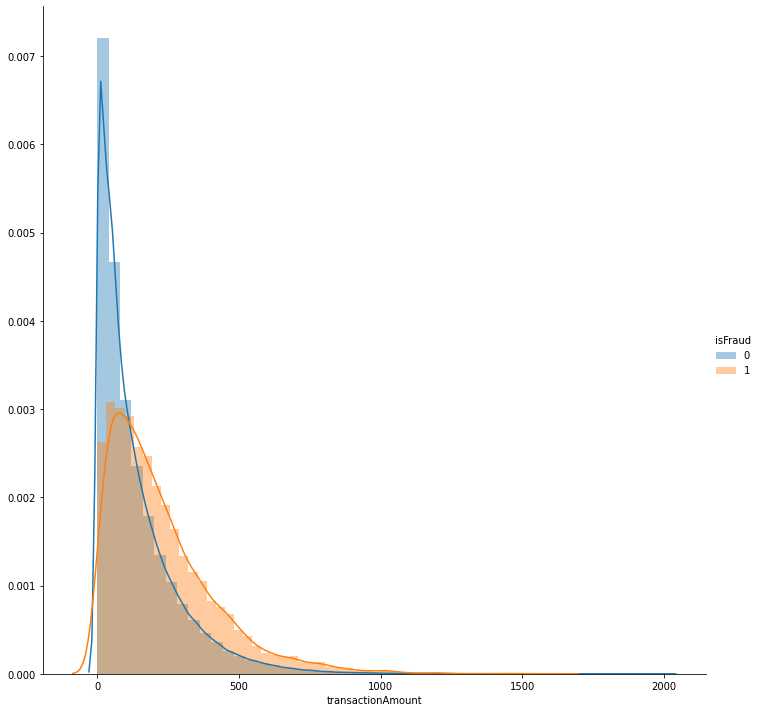

In [29]:
sns.FacetGrid(df, hue="isFraud", size=10).map(sns.distplot, "transactionAmount").add_legend()
plt.show()

*Feature 'isFraud' is the response variable and it takes value 1 in case of fraud and 0 otherwise.*

In [30]:
df_feature = df.drop(columns='isFraud')

df_target = df[['isFraud']]

num_data = df_feature.select_dtypes(include=np.number)

cat_data = df_feature.select_dtypes(include=object)

In [31]:
num_data.head()

,creditLimit,availableMoney,transactionAmount,currentBalance
0,5000.0,5000.0,98.55,0.0
1,5000.0,5000.0,74.51,0.0
2,5000.0,5000.0,7.47,0.0
3,5000.0,5000.0,7.47,0.0
4,5000.0,5000.0,71.18,0.0


In [32]:
cat_data.head()

,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,transactionType,cardPresent,expirationDateKeyInMatch,CorrectCVV
0,US,US,2.0,1.0,rideshare,PURCHASE,False,False,Correct
1,US,US,9.0,1.0,entertainment,PURCHASE,True,False,Correct
2,US,US,9.0,1.0,mobileapps,PURCHASE,False,False,Correct
3,US,US,9.0,1.0,mobileapps,PURCHASE,False,False,Correct
4,US,US,2.0,1.0,fastfood,PURCHASE,True,False,Correct


In [33]:
oe = OrdinalEncoder()

cat_oe = oe.fit_transform(cat_data)

cat_df = pd.DataFrame(cat_oe,columns=cat_data.columns)

In [34]:
cat_df

,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,transactionType,cardPresent,expirationDateKeyInMatch,CorrectCVV
0,3.0,3.0,0.0,0.0,17.0,1.0,0.0,0.0,0.0
1,3.0,3.0,2.0,0.0,3.0,1.0,1.0,0.0,0.0
2,3.0,3.0,2.0,0.0,12.0,1.0,0.0,0.0,0.0
3,3.0,3.0,2.0,0.0,12.0,1.0,0.0,0.0,0.0
4,3.0,3.0,0.0,0.0,4.0,1.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
786358,3.0,3.0,4.0,0.0,17.0,1.0,0.0,0.0,0.0
786359,3.0,3.0,2.0,0.0,15.0,1.0,0.0,0.0,0.0
786360,3.0,3.0,0.0,0.0,17.0,1.0,0.0,0.0,0.0
786361,3.0,3.0,2.0,2.0,14.0,1.0,0.0,0.0,0.0


In [35]:
#for numerical data

sc = StandardScaler()

num_sc = sc.fit_transform(num_data)

num_df = pd.DataFrame(num_sc,columns=num_data.columns)

In [36]:
num_df

,creditLimit,availableMoney,transactionAmount,currentBalance
0,-0.494962,-0.140835,-0.260184,-0.698224
1,-0.494962,-0.140835,-0.422918,-0.698224
2,-0.494962,-0.140835,-0.876733,-0.698224
3,-0.494962,-0.140835,-0.876733,-0.698224
4,-0.494962,-0.140835,-0.445460,-0.698224
...,...,...,...,...
786358,3.372290,4.802984,-0.115524,-0.528646
786359,3.372290,4.789480,-0.799427,-0.510075
786360,3.372290,4.787353,-0.592693,-0.507150
786361,3.372290,4.781787,-0.589579,-0.499495


In [37]:
Data = pd.concat([num_df,cat_df],axis=1)

In [38]:
Data.head()

,creditLimit,availableMoney,transactionAmount,currentBalance,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,transactionType,cardPresent,expirationDateKeyInMatch,CorrectCVV
0,-0.494962,-0.140835,-0.260184,-0.698224,3.0,3.0,0.0,0.0,17.0,1.0,0.0,0.0,0.0
1,-0.494962,-0.140835,-0.422918,-0.698224,3.0,3.0,2.0,0.0,3.0,1.0,1.0,0.0,0.0
2,-0.494962,-0.140835,-0.876733,-0.698224,3.0,3.0,2.0,0.0,12.0,1.0,0.0,0.0,0.0
3,-0.494962,-0.140835,-0.876733,-0.698224,3.0,3.0,2.0,0.0,12.0,1.0,0.0,0.0,0.0
4,-0.494962,-0.140835,-0.445460,-0.698224,3.0,3.0,0.0,0.0,4.0,1.0,1.0,0.0,0.0


## Train and Test Data Split

In [39]:
X = Data.copy()
y = df_target.copy()


In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [41]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(629090, 13)
(157273, 13)
(629090, 1)
(157273, 1)


In [42]:
X_train

,creditLimit,availableMoney,transactionAmount,currentBalance,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,transactionType,cardPresent,expirationDateKeyInMatch,CorrectCVV
323244,0.364427,-0.256567,-0.736879,1.009541,3.0,3.0,2.0,0.0,5.0,1.0,1.0,0.0,0.0
722095,-0.903172,-0.687814,-0.836388,-0.681561,3.0,3.0,2.0,0.0,3.0,1.0,1.0,0.0,0.0
123059,-0.838718,-0.631247,-0.920057,-0.643212,3.0,3.0,1.0,1.0,14.0,1.0,0.0,0.0,1.0
656140,-0.494962,-0.362807,3.386716,-0.392951,3.0,3.0,1.0,0.0,4.0,1.0,1.0,0.0,0.0
720009,-0.709810,-0.644445,-0.878155,-0.392770,3.0,3.0,1.0,0.0,10.0,1.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
359783,-0.065268,-0.197864,-0.583012,0.154507,3.0,3.0,3.0,0.0,4.0,1.0,1.0,0.0,0.0
152315,3.372290,3.684541,-0.053855,1.009524,3.0,3.0,1.0,0.0,16.0,1.0,1.0,0.0,0.0
117952,-0.709810,-0.604847,-0.927300,-0.447228,3.0,3.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0
435829,0.794122,0.194054,-0.371201,1.164112,3.0,3.0,0.0,0.0,18.0,1.0,0.0,0.0,0.0


In [43]:
y_test.value_counts()

isFraud
0          154841
1            2432
dtype: int64

## Model 1 - Random Forest Classifier

In [44]:
#oversampling

In [45]:
rf_classifier = RandomForestClassifier(n_estimators=20, criterion='entropy', random_state = 0)

In [46]:
rf_classifier.fit(X_train, y_train)

/var/folders/d1/r_hn5h_d7n97jdxnl4l21bh40000gn/T/ipykernel_2107/31409248.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_classifier.fit(X_train, y_train)


RandomForestClassifier(criterion='entropy', n_estimators=20, random_state=0)

In [47]:
y_pred = rf_classifier.predict(X_test)

In [48]:
print("Classification report - Random Forest Classifier\n\n", classification_report(y_test, y_pred))

Classification report - Random Forest Classifier

               precision    recall  f1-score   support

           0       0.98      1.00      0.99    154841
           1       0.08      0.00      0.01      2432

    accuracy                           0.98    157273
   macro avg       0.53      0.50      0.50    157273
weighted avg       0.97      0.98      0.98    157273



In [49]:
confusion_matrix(y_test, y_pred)

array([[154742,     99],
       [  2423,      9]])

In [50]:
acc_rf = rf_classifier.score(X_test, y_test)

In [51]:
print(f'Accuracy of Random Forest model on test dataset :- {acc_rf}')

Accuracy of Random Forest model on test dataset :- 0.9839641896574746


## Model 2 - Decision Tree Classifier

In [52]:
dt_classifier = DecisionTreeClassifier()

In [53]:
dt_classifier.fit(X_train, y_train)

DecisionTreeClassifier()

In [54]:
y_pred_dt = dt_classifier.predict(X_test)

In [55]:
print("Classification Report - Decision Tree Classifier\n\n",classification_report(y_test, y_pred_dt))

Classification Report - Decision Tree Classifier

               precision    recall  f1-score   support

           0       0.99      0.98      0.98    154841
           1       0.05      0.05      0.05      2432

    accuracy                           0.97    157273
   macro avg       0.52      0.52      0.52    157273
weighted avg       0.97      0.97      0.97    157273



In [56]:
confusion_matrix(y_test, y_pred_dt)

array([[152242,   2599],
       [  2307,    125]])

In [57]:
acc_dt = dt_classifier.score(X_test, y_test)
print(f'Accuracy of model on test dataset :- {acc_dt}')

Accuracy of model on test dataset :- 0.9688058344407495


## Improving Model Using Sampling Techniques

### Undersampling

In [58]:
class_val = df['isFraud'].value_counts()

In [59]:
class_val

0    773946
1     12417
Name: isFraud, dtype: int64

In [60]:
non_fraud = class_val[0]
fraud = class_val[1]

In [61]:
print(f"Non Fraudulent Numbers :- {non_fraud}")
print(f"Fraudulent Numbers :- {fraud}")

Non Fraudulent Numbers :- 773946
Fraudulent Numbers :- 12417


In [62]:
nonfraud_indexies = df[df.isFraud == 0].index
fraud_indices = np.array(df[df['isFraud'] == 1].index)
# take random samples from non fraudulent that are equal to fraudulent samples
random_normal_indexies = np.random.choice(nonfraud_indexies, fraud, replace=False)
random_normal_indexies = np.array(random_normal_indexies)

In [63]:
under_sample_indices = np.concatenate([fraud_indices, random_normal_indexies])

In [64]:
under_sample_data = Data.iloc[under_sample_indices, :]

In [65]:
under_sample_data

,creditLimit,availableMoney,transactionAmount,currentBalance,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,transactionType,cardPresent,expirationDateKeyInMatch,CorrectCVV
694,3.372290,0.266089,0.191397,5.710850,3.0,3.0,2.0,1.0,10.0,1.0,0.0,0.0,0.0
971,0.364427,0.885422,1.095710,-0.561012,3.0,3.0,2.0,0.0,14.0,1.0,0.0,0.0,0.0
1072,0.364427,0.839087,1.827066,-0.497288,3.0,3.0,2.0,0.0,10.0,1.0,0.0,0.0,0.0
1113,0.364427,0.303223,2.046527,0.239674,3.0,3.0,2.0,0.0,14.0,1.0,0.0,0.0,0.0
1321,0.364427,-0.115721,0.873947,0.815839,3.0,3.0,2.0,0.0,14.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
252635,-0.494962,-0.294980,-0.857237,-0.486231,3.0,3.0,2.0,0.0,13.0,1.0,0.0,0.0,0.0
738105,0.364427,0.697544,-0.203592,-0.302628,3.0,3.0,1.0,0.0,3.0,1.0,1.0,0.0,0.0
38994,0.364427,-0.545990,-0.541720,1.407579,3.0,3.0,2.0,0.0,13.0,1.0,0.0,0.0,0.0
614930,-0.065268,-0.091929,-0.473823,0.008818,3.0,3.0,0.0,0.0,14.0,1.0,0.0,0.0,0.0


In [66]:
y_under_sample_data = df_target.iloc[under_sample_indices, :]

In [67]:
y_under_sample_data

,isFraud
694,1
971,1
1072,1
1113,1
1321,1
...,...
252635,0
738105,0
38994,0
614930,0


In [68]:
x_undersample_data = under_sample_data
y_undersample_data = y_under_sample_data[['isFraud']]

In [69]:
x_undersample_data

,creditLimit,availableMoney,transactionAmount,currentBalance,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,transactionType,cardPresent,expirationDateKeyInMatch,CorrectCVV
694,3.372290,0.266089,0.191397,5.710850,3.0,3.0,2.0,1.0,10.0,1.0,0.0,0.0,0.0
971,0.364427,0.885422,1.095710,-0.561012,3.0,3.0,2.0,0.0,14.0,1.0,0.0,0.0,0.0
1072,0.364427,0.839087,1.827066,-0.497288,3.0,3.0,2.0,0.0,10.0,1.0,0.0,0.0,0.0
1113,0.364427,0.303223,2.046527,0.239674,3.0,3.0,2.0,0.0,14.0,1.0,0.0,0.0,0.0
1321,0.364427,-0.115721,0.873947,0.815839,3.0,3.0,2.0,0.0,14.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
252635,-0.494962,-0.294980,-0.857237,-0.486231,3.0,3.0,2.0,0.0,13.0,1.0,0.0,0.0,0.0
738105,0.364427,0.697544,-0.203592,-0.302628,3.0,3.0,1.0,0.0,3.0,1.0,1.0,0.0,0.0
38994,0.364427,-0.545990,-0.541720,1.407579,3.0,3.0,2.0,0.0,13.0,1.0,0.0,0.0,0.0
614930,-0.065268,-0.091929,-0.473823,0.008818,3.0,3.0,0.0,0.0,14.0,1.0,0.0,0.0,0.0


In [70]:
y_undersample_data

,isFraud
694,1
971,1
1072,1
1113,1
1321,1
...,...
252635,0
738105,0
38994,0
614930,0


In [71]:
y_undersample_data.value_counts()

isFraud
0          12417
1          12417
dtype: int64

### Train and Test Data Split 

In [72]:
X_train_sample, X_test_sample, y_train_sample, y_test_sample = train_test_split(
x_undersample_data, y_undersample_data, test_size=0.2, random_state=0)


In [73]:
y_train_sample.value_counts()

isFraud
0          9934
1          9933
dtype: int64

In [74]:
y_test_sample.value_counts()

isFraud
1          2484
0          2483
dtype: int64

In [75]:
X_train_sample.shape

(19867, 13)

In [76]:
X_test_sample.shape

(4967, 13)

### Random Forest Classifier - Undersampling

In [77]:
rf_classifier_2 = RandomForestClassifier(n_estimators=9, criterion='entropy', random_state = 0)

In [78]:
rf_classifier_2.fit(X_train_sample, y_train_sample)

/var/folders/d1/r_hn5h_d7n97jdxnl4l21bh40000gn/T/ipykernel_2107/3337407466.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_classifier_2.fit(X_train_sample, y_train_sample)


RandomForestClassifier(criterion='entropy', n_estimators=9, random_state=0)

In [79]:
y_undersample_pred = rf_classifier_2.predict(X_test_sample)

In [80]:
print("Classification Report - Random Forest Classifier\n\n",
      classification_report(y_test_sample, y_undersample_pred))

Classification Report - Random Forest Classifier

               precision    recall  f1-score   support

           0       0.66      0.66      0.66      2483
           1       0.66      0.65      0.66      2484

    accuracy                           0.66      4967
   macro avg       0.66      0.66      0.66      4967
weighted avg       0.66      0.66      0.66      4967



In [81]:
confusion_matrix(y_test_sample, y_undersample_pred)

array([[1647,  836],
       [ 857, 1627]])

In [82]:
acc_rf2 = rf_classifier.score(X_test_sample, y_test_sample)

In [83]:
acc_rf2

0.8447755184215825

In [84]:
print(f"AROC score :- \n {roc_auc_score(y_test_sample, y_undersample_pred)}")

AROC score :- 
 0.6591512299741301


### Decision Tree Classifier - Undersampling

In [85]:
dt_classifier_2 = DecisionTreeClassifier()

dt_classifier_2.fit(X_train_sample, y_train_sample)

y_pred_dt2 = dt_classifier_2.predict(X_test_sample)


In [86]:
print("Classification Report - Decision Tree Classifier\n\n",
      classification_report(y_test_sample, y_pred_dt2))



Classification Report - Decision Tree Classifier

               precision    recall  f1-score   support

           0       0.60      0.63      0.61      2483
           1       0.61      0.58      0.60      2484

    accuracy                           0.60      4967
   macro avg       0.60      0.60      0.60      4967
weighted avg       0.60      0.60      0.60      4967



In [87]:
confusion_matrix(y_test_sample, y_pred_dt2)



array([[1554,  929],
       [1034, 1450]])

In [88]:
acc_dt = dt_classifier_2.score(X_test_sample, y_test_sample)
print(f'Accuracy of model on test dataset :- {acc_dt}')

Accuracy of model on test dataset :- 0.6047916247231729


In [89]:
print(f"AROC score :- \n {roc_auc_score(y_test_sample, y_pred_dt2)}")

AROC score :- 
 0.6047958646979816
